# Explaining RandomForestRegressor Trained on Titanic dataset Using UClassificationExplainer.

This is simple example of how to explain predictions for titanic dataset

In [12]:
import numpy as np
import pandas as pd

from ibreakdown import UClassificationExplainer
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
np.set_printoptions(suppress=True)

In [13]:
def read_dataset(columns, seed=None):
    url = (
        'https://web.stanford.edu/class/archive/'
        'cs/cs109/cs109.1166/stuff/titanic.csv'
    )
    df = pd.read_csv(url)
    y = df['Survived']
    X = df[columns]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )
    return X_train, X_test, y_train, y_test

In [14]:
def build_model(num_features, cat_features, seed=None):
    preprocess = make_column_transformer(
        (make_pipeline(SimpleImputer(), StandardScaler()), num_features),
        (OneHotEncoder(categories='auto'), cat_features),
    )
    model = make_pipeline(
        preprocess, RandomForestClassifier(random_state=seed)
    )
    return model

In [15]:
seed = 42
columns = [
    'Age',  # num
    'Fare',  # num
    'Siblings/Spouses Aboard',  # num
    'Parents/Children Aboard',  # num
    'Pclass',  # cat
    'Sex',  # cat
]
X_train, X_test, y_train, y_test = read_dataset(columns, seed)

In [16]:
rf = build_model([0, 1, 2, 3], [4, 5], seed=seed)
param_grid = {
    'columntransformer__pipeline__simpleimputer__strategy': ['mean'],
    'randomforestclassifier__min_samples_leaf': [5],
    'randomforestclassifier__min_samples_split': [12],
    'randomforestclassifier__n_estimators': [100],
}

gs = GridSearchCV(
    estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1
)
gs.fit(X_train, y_train)
model = gs.best_estimator_

Lets pick one observation from testing data and predict

In [17]:
observation = X_test[8:9]
observation

,Age,Fare,Siblings/Spouses Aboard,Parents/Children Aboard,Pclass,Sex
723,28.0,7.7375,0,0,3,female


In [18]:
model.predict_proba(X_test[8:9])

array([[0.40544339, 0.59455661]])

In [19]:
class_map = ['Deceased', 'Survived']
classes = [class_map[i] for i in model.classes_]
explainer = UClassificationExplainer(model.predict_proba)
explainer.fit(X_train, columns, classes=classes)

exp = explainer.explain(observation)
exp.print('Survived')

+----+-------------------------+-----------------+----------------+--------------------+
|    | Feature Name            | Feature Value   |   Contribution |   Contribution STD |
|    |                         |                 |       Survived |           Survived |
|----+-------------------------+-----------------+----------------+--------------------|
|  0 | Age                     | 28.0            |    -0.00935416 |         0.00639688 |
|  1 | Fare                    | 7.7375          |     0.119392   |         0.0764297  |
|  2 | Siblings/Spouses Aboard | 0               |     0.0249213  |         0.00809806 |
|  3 | Parents/Children Aboard | 0               |     0.00949439 |         0.00308719 |
|  4 | Pclass                  | 3               |    -0.12178    |         0.0526799  |
|  5 | Sex                     | female          |     0.18517    |         0.0711646  |
+----+-------------------------+-----------------+----------------+--------------------+


In [20]:
exp.df


,Feature Name,Feature Value,Contribution\n Deceased,Contribution STD\n Deceased,Contribution\n Survived,Contribution STD\n Survived
0,Age,28,0.009354,0.006397,-0.009354,0.006397
1,Fare,7.7375,-0.119392,0.076430,0.119392,0.076430
2,Siblings/Spouses Aboard,0,-0.024921,0.008098,0.024921,0.008098
3,Parents/Children Aboard,0,-0.009494,0.003087,0.009494,0.003087
4,Pclass,3,0.121780,0.052680,-0.121780,0.052680
5,Sex,female,-0.185170,0.071165,0.185170,0.071165


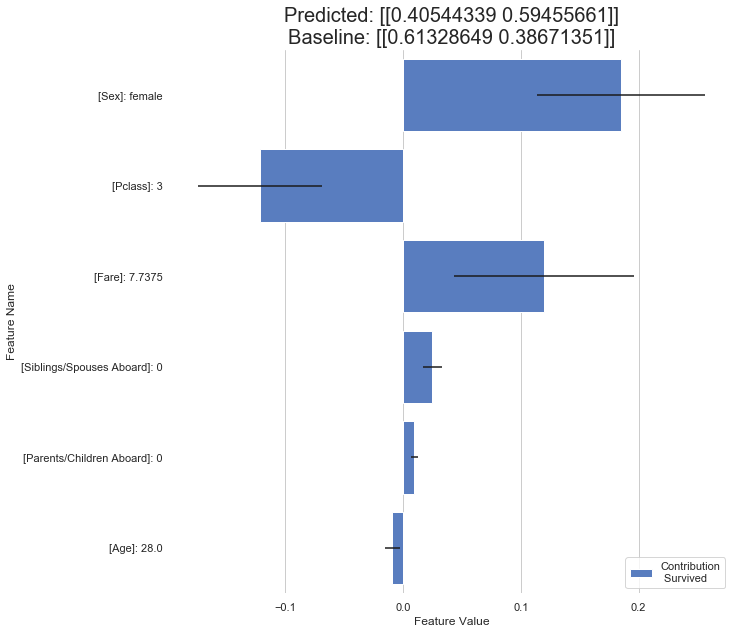

In [21]:
class_ = 'Survived'
exp.plot(class_)